<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-classic-pearson-correlation" data-toc-modified-id="The-classic-pearson-correlation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The classic pearson correlation</a></span></li><li><span><a href="#Bayesian-inference" data-toc-modified-id="Bayesian-inference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bayesian inference</a></span></li><li><span><a href="#Steps-of-Bayesian-data-analysis" data-toc-modified-id="Steps-of-Bayesian-data-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Steps of Bayesian data analysis</a></span></li><li><span><a href="#Step-2---Define-the-descriptive-statistical-model" data-toc-modified-id="Step-2---Define-the-descriptive-statistical-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step 2 - Define the descriptive statistical model</a></span></li><li><span><a href="#Define-the-descriptive-statistical-model-\begin{align*}
y_i-&amp;\sim-MultivariateNormal(\mu_i,-\Sigma)-
\\-\mu_i-&amp;\sim-Normal(0,1)
\\-\Sigma-&amp;=-\sigma-\cdot-\rho
\\-\sigma-&amp;\sim-Lognormal(0,1)
\\-\rho-&amp;\sim-LKJ(1)
\end{align*}" data-toc-modified-id="Define-the-descriptive-statistical-model-\begin{align*}
y_i-&amp;\sim-MultivariateNormal(\mu_i,-\Sigma)-
\\-\mu_i-&amp;\sim-Normal(0,1)
\\-\Sigma-&amp;=-\sigma-\cdot-\rho
\\-\sigma-&amp;\sim-Lognormal(0,1)
\\-\rho-&amp;\sim-LKJ(1)
\end{align*}-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define the descriptive statistical model <div class="MathJax_Display" style="text-align: center;"></div><script type="math/tex; mode=display" id="MathJax-Element-25">\begin{align*}
y_i &\sim MultivariateNormal(\mu_i, \Sigma) 
\\ \mu_i &\sim Normal(0,1)
\\ \Sigma &= \sigma \cdot \rho
\\ \sigma &\sim Lognormal(0,1)
\\ \rho &\sim LKJ(1)
\end{align*}</script></a></span></li><li><span><a href="#Step-4--use-Bayes-rule" data-toc-modified-id="Step-4--use-Bayes-rule-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Step 4 -use Bayes rule</a></span></li><li><span><a href="#Stan-model-for-multipke-correlation-estimation" data-toc-modified-id="Stan-model-for-multipke-correlation-estimation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Stan model for multipke correlation estimation</a></span></li></ul></div>

In [14]:
# Import analysis packages
%matplotlib inline
import stan as ps
import numpy as np
import pandas as pd
import patsy as pt
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

# The classic pearson correlation 

# Bayesian inference
<font size = "3"> Following the quick description of the classic one sample t-test above its important to keep in mind that Bayesian analysis inference are all derived from the applciation of Bayes rule $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$ and as such while the following description of the Bayesian model is an equivalent to pearspn correlation, it is fundamentally different, because it uses fully probabilistic modelling and the infernce is not based on sampling distributions</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

## Bayesian correlation comes many ways

The follwoing models like many Bayesian models can be parameterised in many ways to give the same inferences. For models that are used to calculate correlations are good resource to see this variation is https://solomonkurz.netlify.app/post/2019-02-16-bayesian-correlations-let-s-talk-options/ blog. For the notebook here a the final parameterisation of that blog is shown, however the code here being much simpler and therefore easier to understand than the work around method used in Brms package.

# Steps of Bayesian data analysis

<font size = "3"> Kruscke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. In the case of scientific research publication is the goal, as such the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to acsetain os the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interprete and the posterior

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

In [15]:
url = 'https://gist.githubusercontent.com/ZeccaLehn/4e06d2575eb9589dbe8c365d61cb056c/raw/898a40b035f7c951579041aecbfb2149331fa9f6/mtcars.csv'
df = pd.read_csv(url)

# Step 2 - Define the descriptive statistical model

# Define the descriptive statistical model \begin{align*}
y_{ij} &\sim MultivariateNormal(\mu_{ij}, \Sigma) 
\\ \mu &= [0,0]
\\ \sigma &= [1,1]
\\ \rho &\sim LKJ(1)
\\ \Sigma &= 
\end{align*} 

As stated above the model above allows for the esitmation of correltaion between variables similaryly to classic Pearson correlation. The biggest differnce here though is becuase we are only interested in the correltaions we can standardise the data and then assume that the $\mu's$ & $\sigma's$ are known in the model as they are not of interest in this case whilst still preserving the  same covariance in the data to estimate correlation between the variables of interest. This method becomes more vavlualbe as the number of correltions you wish to estiamte increases as it greatly reduces the number of parameters that are needed to be modelled.

# Step 4 -use Bayes rule

# Stan model for multiple correlation estimation

In [16]:
Correlation_model = """
data{

int<lower = 0> N; // Number of data points
int<lower = 0> K; // Number of correlates
vector[K] y[N]; // vectorised form of matrix

// Assumed know parameter values
vector[K] mu;
vector[K] sigma;

}

parameters{

// Correlation matrix
corr_matrix[K] rho;

}

model{

// Covariance matrix
matrix[K,K] Sigma;
Sigma = quad_form_diag(rho,sigma);

// Uniform prior for correlation parameters
rho ~ lkj_corr(1);

//Likelihood
y ~ multi_normal(mu, Sigma);

}   
"""

In [17]:
#df[["Household_Income", "Population_Mean_Income"]].as_matrix
#y = pd.concat([df['Household_Income'],df['Population_Mean_Income']], axis=1)

y = pd.concat([stats.zscore(df['mpg']), stats.zscore(df['wt'])], axis=1)

data = {'N': len(y),
       "K": y.shape[1],
       'y': y.values, 
       'mu': np.repeat(0,y.shape[1]),
        'sigma': np.repeat(1,y.shape[1])}

In [18]:
sm = ps.build(Correlation_model, data = data, random_seed = 1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xppihbjw/model_falprxs3.stan', line 28, column 0: It is suggested to reparameterize your model to replace lkj_corr with lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run slower, consume more memory, and has higher risk of numerical errors.


In [25]:
# Remove is want to see any of the verbose warnings
fit = sm.hmc_nuts_diag_e_adapt(num_chains= 2, num_samples = 1000, stepsize = .95)

Sampling:   0%
Sampling:  50% (2000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf: y is not positive definite. (in '/tmp/httpstan_r3h1h8c5/model_falprxs3.stan', line 28, column 0 to column 18)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Informational Message: The curren

In [20]:
az.summary(fit)

NameError: name 'fit' is not defined

In [126]:
# Put sample into to pandas dataframe
frame = fit.to_frame()

## Step 5 - Posterior predictive checks

For this correlation model some of these checks make less sense, because implicitly many of the parameters are assumed to be known as 0 or 1, and we are only interested to how mucxh the variables are correlated. However posterior checks to see if posterior samples have no pathological issues.

## Posterior

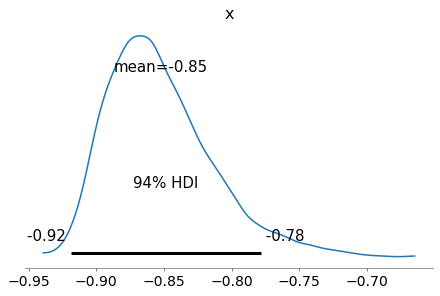

In [128]:
az.plot_posterior(frame['rho.2.1'].values);

## Traceplots

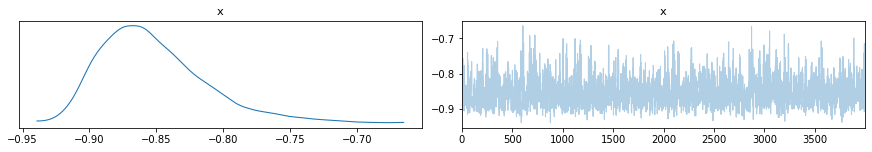

In [139]:
az.plot_trace(frame['rho.2.1'].values);

Traceplot shows no pathlogical issue with good chain mixing 'Fuzzy caterpillars'

## Autocorrelation plots

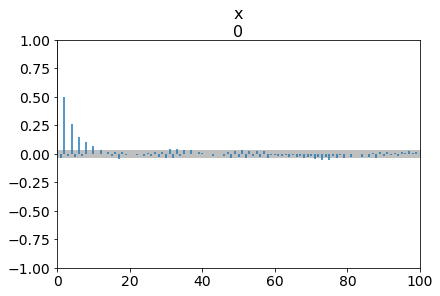

In [140]:
az.plot_autocorr(frame['rho.2.1'].values);

Autocorreltion plot shows no majot issues, quickly returning to 0.

# Reporting the results of the Bayesian correlation

<font size = "3">As Kruschke correctly points out there is no standard formula for presentation of results of Bayesian data analysis in journal articles like the APA guide for reporting frequentist analysis . It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) argue visualisations maybe even more key for decribing and analysis (show dont tell); as such the all the visualisations used above would likely be included with any write up. Anyhow, the write up below generally follows the advice of Kruschke (2015) chapter 25. In any application though it comes down to the problem to be described and the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

In [ ]:
.sample()